# Resolving the issue with continuing a simulation

Last week we have implemented an SI epidemic spreading model, and mentioned that one of the decisions we have to make is how many timesteps to simulate. We discussed that in addition to various heuristics we can use to guess when to stop, one option is to not stop: to return or store the state of the simulation, keeping open the possibility of continuing the simulation.

We did the following test to check that our code works correctly: we ran a simulation for 2x20 timesteps, and then re-ran the last 20 timesteps again. We got the following:

In [1]:
import networkx, random
import matplotlib.pyplot as plt
import copy
S = 'S'; I = 'I'

def si_infection_model__initialize(g, Lambda):
    node_states = {node:S for node in g.nodes()}
    node_states[random.choice(list(g.nodes()))] = I # start with one, randomly chosen node in I state
    
    result = []
    num_infected_nodes = len([node for node in g.nodes() if node_states[node] == I])
    result.append(num_infected_nodes)
    
    return result, g, Lambda, node_states

def si_infection_model__run_some_steps(result, g, Lambda, node_states, num_timesteps):
    for timestep in range(num_timesteps):
        for node in g.nodes(): # for each time-step, iterate over all nodes and try to infect neighbors:
            if node_states[node] is I:
                for neighbor in g.neighbors(node):
                    if random.random() < Lambda:
                        node_states[neighbor] = I
        num_infected_nodes = len([node for node in g.nodes() if node_states[node] == I])
        result.append(num_infected_nodes)
    
    return result, g, Lambda, node_states

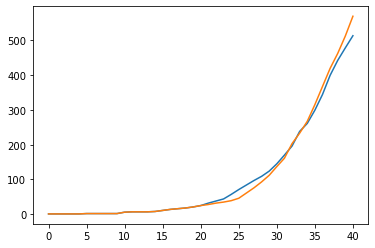

In [2]:
result, g, Lambda, node_states = si_infection_model__initialize(networkx.gnp_random_graph(1000, 0.2), 0.001)
result, g, Lambda, node_states = si_infection_model__run_some_steps(result, g, Lambda, node_states, 20)
backup_of_state = copy.deepcopy((result, g, Lambda, node_states))
# first run:
result_first_run, g, Lambda, node_states = si_infection_model__run_some_steps(result, g, Lambda, node_states, 20)

# second run, re-running the second 20 steps:
result, g, Lambda, node_states = backup_of_state
result_second_run, g, Lambda, node_states = si_infection_model__run_some_steps(result, g, Lambda, node_states, 20)

plt.plot(result_first_run)
plt.plot(result_second_run)

As the plot above shows, the two results differ after the first 20 steps, i.e. our "save & restore state" does not work fully correctly. As we mentioned, we shouldn't accept such a difference, no matter how small, since the "store the state and continue / re-run the simulation" should be able to fully reproduce the previous results.

The issue is very simple to resolve once we know what to look for: we need to ensure that we save & restore the full state of the simulation. The full state, including and variables, datastructures, etc., including the state of the random number generator. As we have seen before, the random module is a Pseudo Random Number Generator (PRNG), which is actually completely deterministic, and we can use random.getstate() and random.setstate() to save & restore the internal state. Adding this to the "state" of the simulation, we can see that we get full reproducibility (shown on the plot below by the fact that only one color is visible, since the two curves are on top of each other):

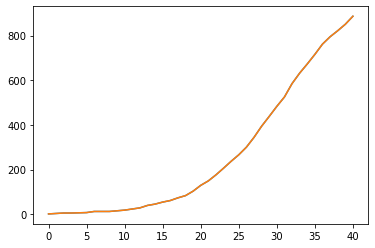

In [3]:
def si_infection_model__initialize2(g, Lambda):
    node_states = {node:S for node in g.nodes()}
    node_states[random.choice(list(g.nodes()))] = I # start with one, randomly chosen node in I state
    
    result = []
    num_infected_nodes = len([node for node in g.nodes() if node_states[node] == I])
    result.append(num_infected_nodes)
    
    return result, g, Lambda, node_states, random.getstate()

def si_infection_model__run_some_steps2(result, g, Lambda, node_states, prng_state, num_timesteps):
    random.setstate(prng_state)
    for timestep in range(num_timesteps):
        for node in g.nodes(): # for each time-step, iterate over all nodes and try to infect neighbors:
            if node_states[node] is I:
                for neighbor in g.neighbors(node):
                    if random.random() < Lambda:
                        node_states[neighbor] = I
        num_infected_nodes = len([node for node in g.nodes() if node_states[node] == I])
        result.append(num_infected_nodes)
    
    return result, g, Lambda, node_states, random.getstate()

import copy
result, g, Lambda, node_states, prng_state = si_infection_model__initialize2(networkx.gnp_random_graph(1000, 0.2), 0.001)
result, g, Lambda, node_states, prng_state = si_infection_model__run_some_steps2(result, g, Lambda, node_states, prng_state, 20)
backup_of_state = copy.deepcopy((result, g, Lambda, node_states, prng_state))
# first run:
result_first_run, g, Lambda, node_states, prng_state = si_infection_model__run_some_steps2(result, g, Lambda, node_states, prng_state, 20)

# second run, re-running the second 20 steps:
result, g, Lambda, node_states, prng_state = backup_of_state
result_second_run, g, Lambda, node_states, prng_state = si_infection_model__run_some_steps2(result, g, Lambda, node_states, prng_state, 20)

plt.plot(result_first_run)
plt.plot(result_second_run)